In [130]:
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [131]:
pd.set_option('display.max_rows', 500)
pd.set_option('max_columns', 30)

In [132]:
conn = sqlite3.connect('ka_devices.db')

In [133]:
# Read in datasets
actions_dat = pd.read_parquet('ka_actions.parquet', engine='fastparquet')
users_dat = pd.read_csv('ka_users.csv')
devices_dat = pd.read_sql_query("SELECT * FROM devices", conn)

In [134]:
# Remove unnecessary index column in devices
devices_dat.drop(['index'], axis=1, inplace=True)

In [135]:
# Examine size of datasets and to check for nulls in the dataset
print(users_dat.shape); print(devices_dat.shape); print(actions_dat.shape);
print(users_dat['uid_s'].isna().sum())
print(devices_dat['uid_s'].isna().sum())
print(actions_dat['uid_s'].isna().sum())
print(users_dat.isna().sum().sum())
print(devices_dat.isna().sum().sum())
print(actions_dat.isna().sum().sum())

(2845931, 8)
(2845931, 13)
(2845931, 10)
0
0
0
126
26
5244989


In [136]:
# Join datasets by user id
users_devices_joined = users_dat.merge(devices_dat, on='uid_s')
full_dat = users_devices_joined.merge(actions_dat, on='uid_s')

In [137]:
# Remove variables to save memory
del actions_dat
del users_dat
del devices_dat
del users_devices_joined

In [138]:
# Assure that no data is lost when data is joined
print(full_dat.shape)
print(full_dat['uid_s'].isna().sum())
print(full_dat['total_spend'].isna().sum())

(2845931, 29)
0
0


In [139]:
# Before diving into the data further, split the dataset into train(60%) and test(40%) for model evaluation
train, test = train_test_split(full_dat, test_size=0.4, random_state=12)

In [140]:
# At this point, I would like to understand the data a bit more using the training set

# Some questions I would like to figure out:
# Is there value in predicting the spend for users who do not complete the tutorial (0 or NaN)
# Can we use game_stats_xp as an input for predictions

# Make a copy of the training data set to do some exploration in the data
explore_dat = train.copy()

BEGIN OF DATA EXPLORATION

In [141]:
# Add a column spender that denotes whether users spent in lifetime
explore_dat['spender'] = explore_dat['total_spend'] > 0

In [142]:
explore_dat.groupby('game_stats_tutorial_complete', as_index=False, dropna=False).agg(sum_spend=('total_spend','sum'), avg_spend=('total_spend','mean'), prop_spend=('spender','mean'), num_users=('spender','count'))

,game_stats_tutorial_complete,sum_spend,avg_spend,prop_spend,num_users
0,0.0,2555,0.803965,0.006608,3178
1,1.0,1969060,1.872474,0.017514,1051582
2,NaN,112100,0.171722,0.001547,652798


- We can see below that there is still a significant amount of spend coming from users who do not complete the tutorial (0 or NaN)
- Some hypothesis I have would be: purchases can be made even before completing the tutorial, there are users with different devices, and the data is capturing them in different user ids, or tutorials can be skipped
- I think we should still try to make a prediction for these users due to the amount of spend it still brings in (especially for the NaN rows). 
- I think we should try to predict spend for these users separately from the users who do complete the tutorial.

In [143]:
# Add a column that denotes whether a user has gained xp in the forth time interval
explore_dat['game_stats_xp3_conv'] = explore_dat['game_stats_xp3'] > 0

In [144]:
explore_dat.groupby(['game_stats_tutorial_complete','game_stats_xp3_conv'], as_index=False, dropna=False).size()

# We can see after running the line that there is some users that could gain xp later in the game despite not completing the tutorial

,game_stats_tutorial_complete,game_stats_xp3_conv,size
0,0.0,False,3121
1,0.0,True,57
2,1.0,False,960925
3,1.0,True,90657
4,NaN,False,650049
5,NaN,True,2749


In [145]:
# Get the total xp from the 4 time intervals
explore_dat['game_stats_xp_total'] = explore_dat['game_stats_xp'] + explore_dat['game_stats_xp1'] + explore_dat['game_stats_xp2'] + explore_dat['game_stats_xp3']

In [146]:
# Bin the game_stats_xp_total column
bins = [0, 50, 100, 200, 1000, max(explore_dat['game_stats_xp_total'])]
explore_dat['game_stats_xp_total_binned'] = pd.cut(explore_dat['game_stats_xp_total'], bins)

In [147]:
explore_dat.groupby(['game_stats_tutorial_complete','game_stats_xp_total_binned'], as_index=False, dropna=False).size()

,game_stats_tutorial_complete,game_stats_xp_total_binned,size
0,NaN,"(0.0, 50.0]",2412
1,NaN,"(50.0, 100.0]",82999
2,NaN,"(100.0, 200.0]",103933
3,NaN,"(200.0, 1000.0]",5949
4,NaN,"(1000.0, 384433.0]",462
5,0.0,"(0.0, 50.0]",0
6,0.0,"(50.0, 100.0]",76
7,0.0,"(100.0, 200.0]",2200
8,0.0,"(200.0, 1000.0]",683
9,0.0,"(1000.0, 384433.0]",194


- It seems that users who do not complete the tutorial still gain some xp in the time intervals. It suggests that there is some reasonable overlap between the tutorial and first 4 time intervals.

In [148]:
# sns.displot(data=explore_dat[explore_dat['game_stats_tutorial_complete']==1].sample(frac=.2, replace=False, random_state=123), x="game_stats_xp_total")

In [149]:
explore_dat.head()

,uid_s,lang_s,geo_s,region_s,tz_i,local_time_join_hour,local_time_join_dow,total_spend,platform_s,device_mapped_s,device_manufacturer_s,device_mem_i,device_gmem_i,device_mem_grouping_i,device_gmem_grouping_i,...,device_os_s,device_model_s,logins,game_stats_tutorial_complete,game_stats_tutorial_complete_time,game_stats_xp,game_stats_xp1,game_stats_xp2,game_stats_xp3,redeemer_actions,scribe_actions,spender,game_stats_xp3_conv,game_stats_xp_total,game_stats_xp_total_binned
517833,517833,ZH-CN,CN,asia,28800,18,7,0,android,vivo x21a,vivo,1616.0,512.0,1664.0,512.0,...,android os 8.1.0 / api-27 (opm1.171019.011/eng...,vivo x21a,2.0,1.0,6.090000e+08,1311.0,1311.0,0.0,0.0,324.0,245.0,False,False,2622.0,"(1000.0, 384433.0]"
417219,417219,ZH-CN,CN,asia,28800,12,7,0,android,mx4,meizu,1895.0,512.0,1920.0,512.0,...,android os 5.1 / api-22 (lmy47i/1520235784),mx4,3.0,1.0,1.217000e+09,892.0,892.0,0.0,0.0,205.0,197.0,False,False,1784.0,"(1000.0, 384433.0]"
1176959,1176959,ZH-CN,CN,asia,28800,0,3,0,iphone,"iphone11,6",apple,3735.0,1024.0,3776.0,1024.0,...,ios 12.2,"iphone11,6",5.0,1.0,8.440000e+08,689.0,689.0,0.0,0.0,168.0,223.0,False,False,1378.0,"(1000.0, 384433.0]"
585508,585508,ZH-CN,CN,asia,28800,21,7,0,android,oppo a83,oppo,2791.0,1024.0,2816.0,1024.0,...,android os 7.1.1 / api-25 (n6f26q/1554776020),oppo a83,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,False,False,NaN,NaN
2840870,2840870,EN,IN,asia,19800,12,5,0,android,sm-j210f,samsung,1360.0,512.0,1408.0,512.0,...,android os 6.0.1 / api-23 (mmb29q/j210fxxu0arl1),sm-j210f,4.0,NaN,NaN,NaN,NaN,NaN,NaN,12.0,24.0,False,False,NaN,NaN


In [150]:
explore_dat[explore_dat['game_stats_tutorial_complete']==1].groupby('lang_s', as_index=False, dropna=False).agg(avg_spend=('total_spend','mean'), prop_spend=('spender','mean'), num_users=('spender','count'))

,lang_s,avg_spend,prop_spend,num_users
0,AR,0.528426,0.005168,5611
1,DE,3.025414,0.027790,10939
2,EN,1.910679,0.017556,383976
3,ES,0.751815,0.007096,92310
4,FR,1.725268,0.016442,18003
5,ID,0.321435,0.004159,5771
6,IT,2.080139,0.017735,14999
7,JA,4.932676,0.045038,17230
8,KO,2.116788,0.019465,4932
9,NL,1.715210,0.015719,2163


In [151]:
explore_dat[explore_dat['game_stats_tutorial_complete']==1].groupby('region_s', as_index=False, dropna=False).agg(avg_spend=('total_spend','mean'), prop_spend=('spender','mean'), num_users=('spender','count'))

,region_s,avg_spend,prop_spend,num_users
0,africa,0.430697,0.003915,7662
1,americas,2.002500,0.018635,296854
2,asia,1.810940,0.017149,584180
3,europe,1.784845,0.016086,153299
4,oceania,4.145107,0.038598,9586
5,unknown,45.000000,1.000000,1


In [152]:
explore_dat[explore_dat['game_stats_tutorial_complete']==1].groupby('local_time_join_hour', as_index=False, dropna=False).agg(avg_spend=('total_spend','mean'), prop_spend=('spender','mean'), num_users=('spender','count'))

,local_time_join_hour,avg_spend,prop_spend,num_users
0,0,2.788197,0.025792,22875
1,1,2.698043,0.026248,14820
2,2,2.888459,0.028670,9557
3,3,2.545920,0.023487,6642
4,4,2.251509,0.023074,5634
5,5,1.824625,0.016741,7407
6,6,1.869218,0.018078,16539
7,7,1.952276,0.017892,28057
8,8,2.039119,0.019742,35660
9,9,1.957017,0.018237,43482


In [153]:
explore_dat[explore_dat['game_stats_tutorial_complete']==1].groupby('local_time_join_dow', as_index=False, dropna=False).agg(avg_spend=('total_spend','mean'), prop_spend=('spender','mean'), num_users=('spender','count'))

,local_time_join_dow,avg_spend,prop_spend,num_users
0,1,1.743998,0.016305,227053
1,2,2.059688,0.019483,108866
2,3,1.940211,0.018056,102293
3,4,1.760566,0.016586,98457
4,5,1.987609,0.018309,77392
5,6,2.004256,0.018703,162377
6,7,1.809125,0.016937,275144


In [154]:
explore_dat[explore_dat['game_stats_tutorial_complete']==1].groupby('platform_s', as_index=False, dropna=False).agg(avg_spend=('total_spend','mean'), prop_spend=('spender','mean'), num_users=('spender','count'))

,platform_s,avg_spend,prop_spend,num_users
0,android,1.477456,0.013944,793902
1,iphone,3.089510,0.028512,257680


In [155]:
len(explore_dat[explore_dat['game_stats_tutorial_complete']==1]['device_manufacturer_s'].unique())
# There is quite a significant amount of different manufacturer. We could try to group these, but for this assignment, I won't be including them in the models

1674

In [156]:
explore_dat[explore_dat['game_stats_tutorial_complete']==1].groupby('device_numcpu_i', as_index=False, dropna=False).agg(avg_spend=('total_spend','mean'), prop_spend=('spender','mean'), num_users=('spender','count'))

,device_numcpu_i,avg_spend,prop_spend,num_users
0,1.0,0.077786,0.000449,6685
1,2.0,2.172854,0.019959,179018
2,3.0,2.047472,0.020185,10701
3,4.0,0.464941,0.004477,212640
4,5.0,0.426009,0.008969,223
5,6.0,5.061719,0.046794,76313
6,8.0,1.900022,0.017885,562212
7,10.0,1.097464,0.011622,3786
8,16.0,0.000000,0.000000,1
9,20.0,0.000000,0.000000,1


In [157]:
explore_dat[explore_dat['game_stats_tutorial_complete']==1]['device_height_i'].describe()

count    1.051581e+06
mean     9.107231e+02
std      2.552341e+02
min      2.400000e+02
25%      7.200000e+02
50%      8.100000e+02
75%      1.080000e+03
max      2.960000e+03
Name: device_height_i, dtype: float64

In [158]:
explore_dat[explore_dat['game_stats_tutorial_complete']==1].groupby('device_gmem_grouping_i', as_index=False, dropna=False).agg(avg_spend=('total_spend','mean'), prop_spend=('spender','mean'), num_users=('spender','count'))

,device_gmem_grouping_i,avg_spend,prop_spend,num_users
0,128.0,0.000000,0.000000,91
1,256.0,0.572799,0.005046,126039
2,512.0,1.464421,0.013699,339957
3,1024.0,2.038065,0.019019,489089
4,2048.0,4.150244,0.039478,96004
5,4096.0,9.385965,0.077694,399
6,16384.0,0.000000,0.000000,1
7,262144.0,0.000000,0.000000,1
8,NaN,45.000000,1.000000,1


In [159]:
explore_dat['game_stats_tutorial_complete_time'] = explore_dat['game_stats_tutorial_complete_time']/1000000/60

In [160]:
explore_dat['game_stats_tutorial_complete_time'].describe()

count    1.051582e+06
mean     2.916263e+01
std      6.359405e+01
min      3.800000e+00
25%      8.466667e+00
50%      1.061667e+01
75%      1.573333e+01
max      4.800000e+02
Name: game_stats_tutorial_complete_time, dtype: float64

In [161]:
bins = [*range(4, 31, 1)]
explore_dat['game_stats_tutorial_complete_time_binned'] = pd.cut(explore_dat['game_stats_tutorial_complete_time'], bins)

In [162]:
sns_in = explore_dat.groupby(['game_stats_tutorial_complete_time_binned'], as_index=False, dropna=False).agg(avg_spend=('total_spend','mean'), prop_spend=('spender','mean'), num_users=('spender','count'))

<AxesSubplot:xlabel='game_stats_tutorial_complete_time_binned', ylabel='prop_spend'>

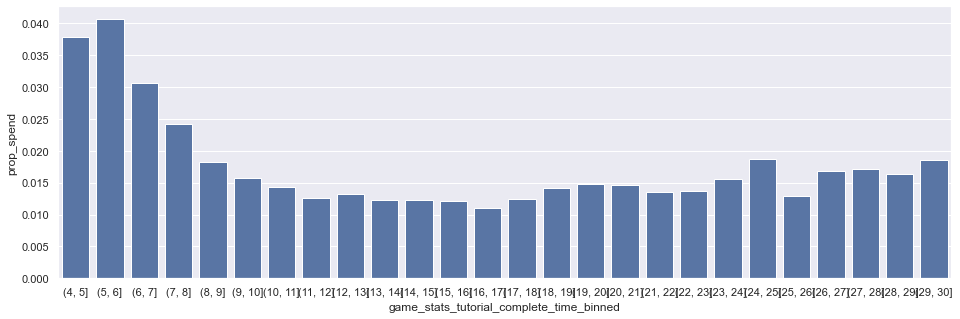

In [163]:
sns.set(rc = {'figure.figsize':(16,5)})
sns.barplot(x="game_stats_tutorial_complete_time_binned", y="prop_spend", data=sns_in, color='b')

In [165]:
bins = [*range(0, 1000, 100)]
explore_dat['game_stats_xp_binned'] = pd.cut(explore_dat['game_stats_xp'], bins)

In [166]:
sns_in = explore_dat.groupby(['game_stats_xp_binned'], as_index=False, dropna=False).agg(avg_spend=('total_spend','mean'), prop_spend=('spender','mean'), num_users=('spender','count'))

<AxesSubplot:xlabel='game_stats_xp_binned', ylabel='prop_spend'>

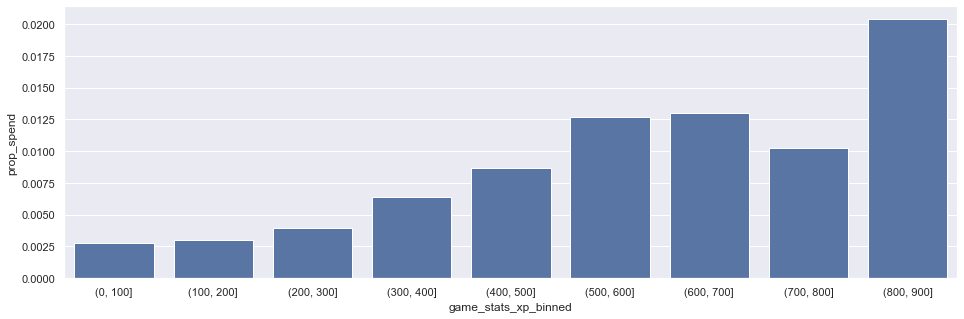

In [167]:
sns.set(rc = {'figure.figsize':(16,5)})
sns.barplot(x="game_stats_xp_binned", y="prop_spend", data=sns_in, color='b')

In [168]:
explore_dat['game_stats_xp_total'].describe()

count    1.250447e+06
mean     1.546271e+03
std      3.665908e+03
min      1.000000e+01
25%      1.800000e+02
50%      6.240000e+02
75%      1.420000e+03
max      3.844330e+05
Name: game_stats_xp_total, dtype: float64

In [169]:
bins = [*range(0, 2000, 100)]
explore_dat['game_stats_xp_total_binned'] = pd.cut(explore_dat['game_stats_xp_total'], bins)

In [170]:
sns_in = explore_dat.groupby(['game_stats_xp_total_binned'], as_index=False, dropna=False).agg(avg_spend=('total_spend','mean'), prop_spend=('spender','mean'), num_users=('spender','count'))

<AxesSubplot:xlabel='game_stats_xp_total_binned', ylabel='prop_spend'>

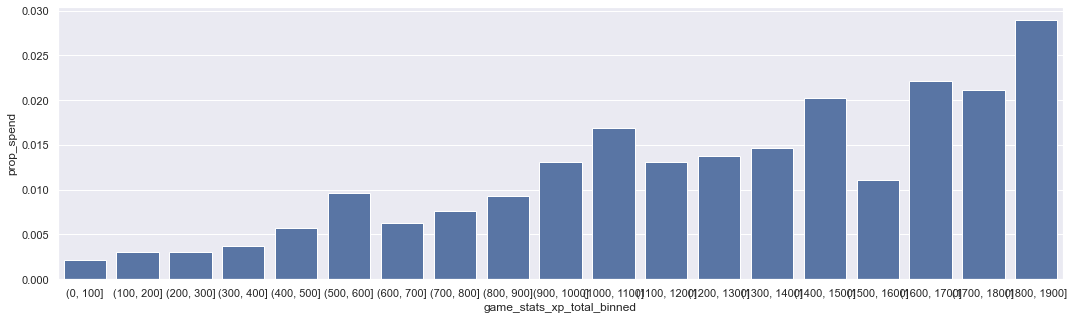

In [171]:
sns.set(rc = {'figure.figsize':(18,5)})
sns.barplot(x="game_stats_xp_total_binned", y="prop_spend", data=sns_in, color='b')

In [172]:
sns_in = explore_dat.groupby(['game_stats_tutorial_complete_time_binned'], as_index=False, dropna=False).agg(avg_game_stats_xp_total=('game_stats_xp_total','mean'))

<AxesSubplot:xlabel='game_stats_tutorial_complete_time_binned', ylabel='avg_game_stats_xp_total'>

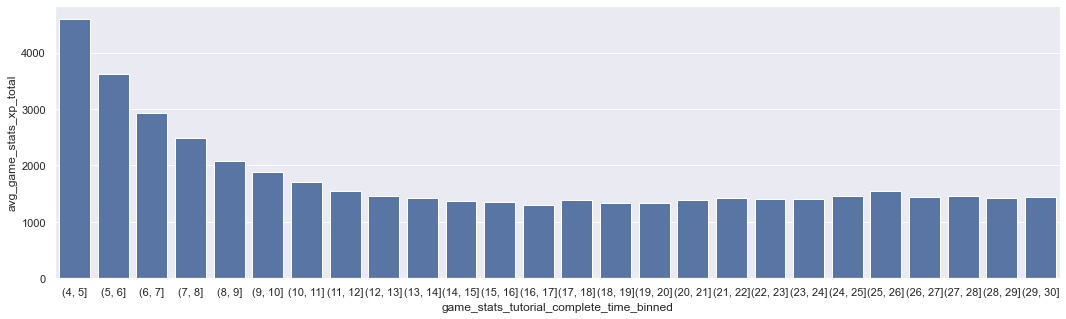

In [173]:
sns.set(rc = {'figure.figsize':(18,5)})
sns.barplot(x="game_stats_tutorial_complete_time_binned", y="avg_game_stats_xp_total", data=sns_in, color='b')

In [174]:
explore_dat['game_stats_xp_3_over_total'] = explore_dat['game_stats_xp3']/explore_dat['game_stats_xp_total']

In [175]:
explore_dat['game_stats_xp_3_over_total'].describe()

count    1.250447e+06
mean     1.571561e-02
std      6.718792e-02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      5.000000e-01
Name: game_stats_xp_3_over_total, dtype: float64

In [176]:
bins = [0, .1, .2, .3, .4, .5]
explore_dat['game_stats_xp_3_over_total_binned'] = pd.cut(explore_dat['game_stats_xp_3_over_total'], bins)

In [177]:
sns_in = explore_dat.groupby(['game_stats_xp_3_over_total_binned'], as_index=False, dropna=False).agg(avg_spend=('total_spend','mean'), prop_spend=('spender','mean'), num_users=('spender','count'))

<AxesSubplot:xlabel='game_stats_xp_3_over_total_binned', ylabel='prop_spend'>

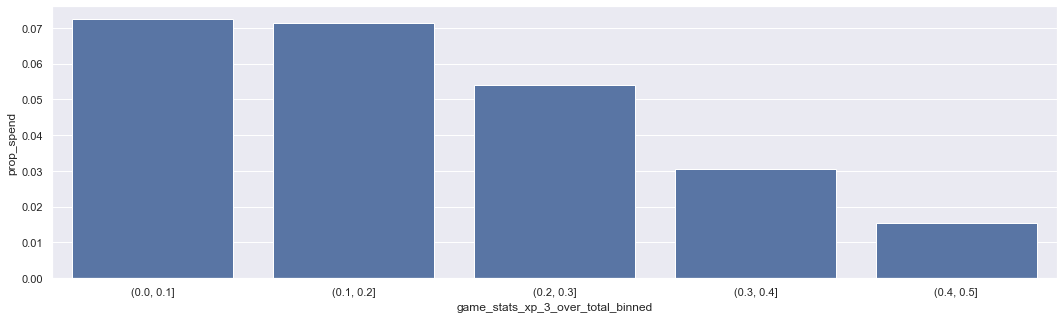

In [178]:
sns.set(rc = {'figure.figsize':(18,5)})
sns.barplot(x="game_stats_xp_3_over_total_binned", y="prop_spend", data=sns_in, color='b')

In [179]:
explore_dat['game_stats_xp_0_over_total'] = explore_dat['game_stats_xp']/explore_dat['game_stats_xp_total']

In [180]:
explore_dat['game_stats_xp_0_over_total'].describe()

count    1.250447e+06
mean     5.322258e-01
std      1.002375e-01
min      4.000000e-01
25%      5.000000e-01
50%      5.000000e-01
75%      5.000000e-01
max      1.000000e+00
Name: game_stats_xp_0_over_total, dtype: float64

In [181]:
bins = [.2, .3, .4, .5, .6, .7, .8, .9, 1]
explore_dat['game_stats_xp_0_over_total_binned'] = pd.cut(explore_dat['game_stats_xp_0_over_total'], bins)

In [182]:
sns_in = explore_dat.groupby(['game_stats_xp_0_over_total_binned'], as_index=False, dropna=False).agg(avg_spend=('total_spend','mean'), prop_spend=('spender','mean'), num_users=('spender','count'))

<AxesSubplot:xlabel='game_stats_xp_0_over_total_binned', ylabel='prop_spend'>

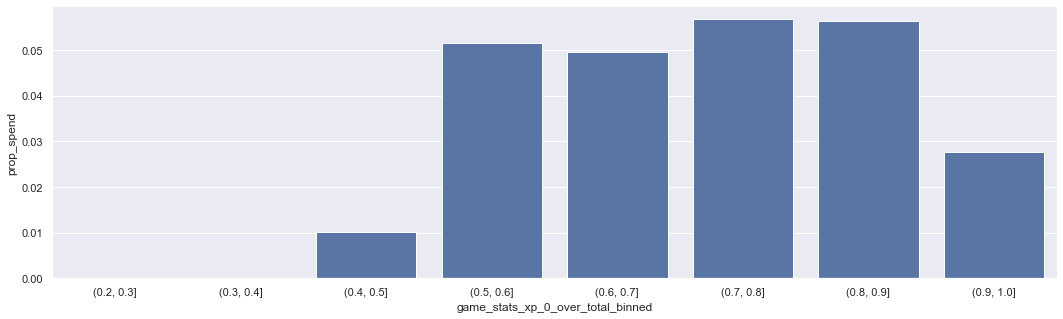

In [183]:
sns.set(rc = {'figure.figsize':(18,5)})
sns.barplot(x="game_stats_xp_0_over_total_binned", y="prop_spend", data=sns_in, color='b')

In [184]:
explore_dat['game_stats_xp_conv'] = explore_dat['game_stats_xp'] > 0
explore_dat['game_stats_xp1_conv'] = explore_dat['game_stats_xp1'] > 0
explore_dat['game_stats_xp2_conv'] = explore_dat['game_stats_xp2'] > 0
explore_dat['game_stats_xp_num_conv'] = explore_dat['game_stats_xp_conv'].astype(int) + explore_dat['game_stats_xp1_conv'].astype(int) + explore_dat['game_stats_xp2_conv'].astype(int) + explore_dat['game_stats_xp3_conv'].astype(int)

In [185]:
sns_in = explore_dat.groupby(['game_stats_xp_conv'], as_index=False, dropna=False).agg(avg_spend=('total_spend','mean'), prop_spend=('spender','mean'), num_users=('spender','count'))

<AxesSubplot:xlabel='game_stats_xp_conv', ylabel='prop_spend'>

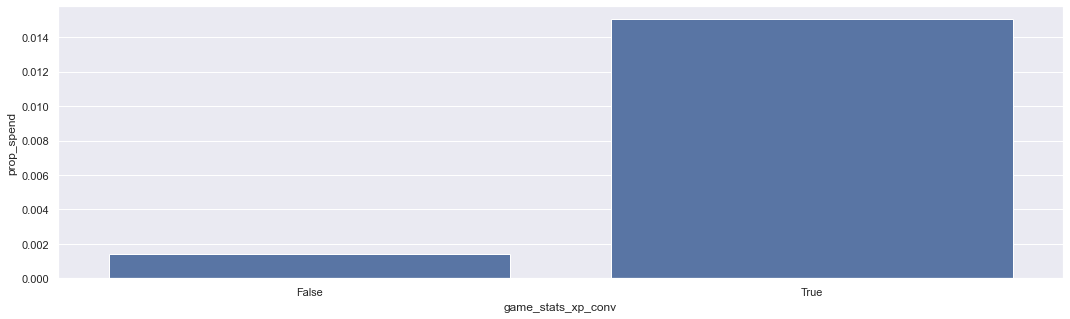

In [186]:
sns.set(rc = {'figure.figsize':(18,5)})
sns.barplot(x="game_stats_xp_conv", y="prop_spend", data=sns_in, color='b')

In [187]:
sns_in = explore_dat.groupby(['game_stats_xp3_conv'], as_index=False, dropna=False).agg(avg_spend=('total_spend','mean'), prop_spend=('spender','mean'), num_users=('spender','count'))

<AxesSubplot:xlabel='game_stats_xp3_conv', ylabel='prop_spend'>

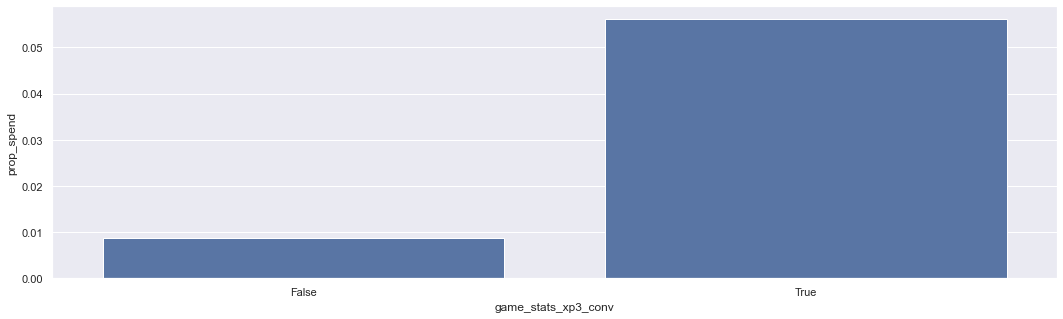

In [188]:
sns.set(rc = {'figure.figsize':(18,5)})
sns.barplot(x="game_stats_xp3_conv", y="prop_spend", data=sns_in, color='b')

In [189]:
sns_in = explore_dat.groupby(['game_stats_xp_num_conv'], as_index=False, dropna=False).agg(avg_spend=('total_spend','mean'), prop_spend=('spender','mean'), num_users=('spender','count'))

<AxesSubplot:xlabel='game_stats_xp_num_conv', ylabel='prop_spend'>

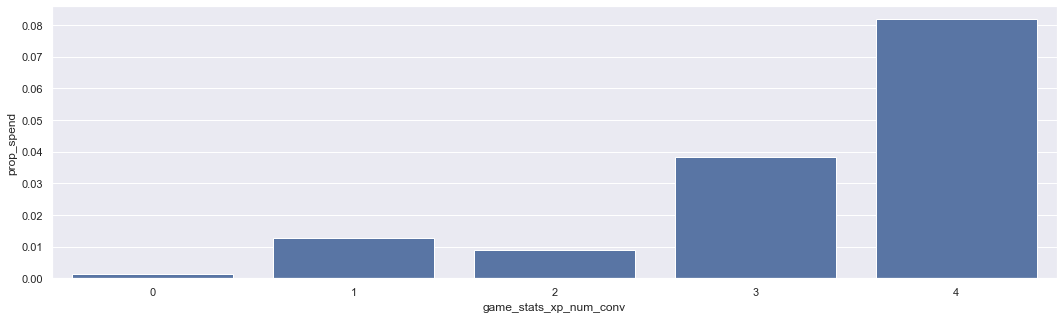

In [190]:
sns.set(rc = {'figure.figsize':(18,5)})
sns.barplot(x="game_stats_xp_num_conv", y="prop_spend", data=sns_in, color='b')

In [191]:
explore_dat['total_spend_over_logins'] = explore_dat['total_spend']/explore_dat['logins']

END OF DATA EXPLORATION

In [192]:
def select_features_and_target(x):
    """
    Hard-coded features and target to keep from the data. (All models run this)
    """
    features_and_target = ['region_s','local_time_join_hour','local_time_join_dow','platform_s','device_gmem_grouping_i','device_numcpu_i','device_height_i','game_stats_tutorial_complete','game_stats_tutorial_complete_time',
                            'game_stats_xp','game_stats_xp1','game_stats_xp2','game_stats_xp3','total_spend']
    return x[features_and_target]
    
def replace_target(x):
    """
    Select features to keep from the data. (All models run this)
    """
    x['spender'] = x['total_spend'] > 0
    x.drop(['total_spend'], axis=1, inplace=True)
    return x

def preprocess_clean(x):
    """
    Further clean up of any columns
    """
    dict_to_replace = {'unknown': 'africa'} # unknown value under region_s only has one record, just move it into africa, the single record won't majory impact the results
    x = x.replace({'region_s': dict_to_replace})
    x['game_stats_tutorial_complete_time'] = x['game_stats_tutorial_complete_time']/(60*1000000)
    return x

def fill_in_missing(x):
    x['game_stats_tutorial_complete'] = x['game_stats_tutorial_complete'].fillna(0)
    x['game_stats_xp'] = x['game_stats_xp'].fillna(0)
    x['game_stats_xp1'] = x['game_stats_xp1'].fillna(0)
    x['game_stats_xp2'] = x['game_stats_xp2'].fillna(0)
    x['game_stats_xp3'] = x['game_stats_xp3'].fillna(0)
    return x

def add_new_features(x):
    """
    Additional features to add into feature vector. There was some signal from exploring the data.
    """
    x['game_stats_xp_total'] = x['game_stats_xp'] + x['game_stats_xp1'] + x['game_stats_xp2'] + x['game_stats_xp3'] # Total xp on first 4 time intervals
    x['game_stats_xp_conv'] = x['game_stats_xp'] > 0 # Did the user gain any xp in the first time interval
    x['game_stats_xp1_conv'] = x['game_stats_xp1'] > 0
    x['game_stats_xp2_conv'] = x['game_stats_xp2'] > 0
    x['game_stats_xp3_conv'] = x['game_stats_xp3'] > 0
    # Out of the 4 time intervals, how many of the intervals did the user gain xp in
    x['game_stats_xp_num_conv'] = x['game_stats_xp_conv'].astype(int) + x['game_stats_xp1_conv'].astype(int) + x['game_stats_xp2_conv'].astype(int) + x['game_stats_xp3_conv'].astype(int)
    return x

def transform_features(x):
    """
    Convert the hour and dow features so it better represents a cyclical feature
    """
    x['hour_sin'] = np.sin(2*np.pi*x['local_time_join_hour']/24)
    x['hour_cos'] = np.cos(2*np.pi*x['local_time_join_hour']/24)
    x.drop(['local_time_join_hour'], axis=1, inplace=True)

    x['dow_sin'] = np.sin(2*np.pi*(x['local_time_join_dow']-1)/7)
    x['dow_cos'] = np.cos(2*np.pi*(x['local_time_join_dow']-1)/7)
    x.drop(['local_time_join_dow'], axis=1, inplace=True)

    #x.loc[x['game_stats_tutorial_complete_time'] > 60, 'game_stats_tutorial_complete_time'] = 60
    return x

def standardize_cols(x):
    cols_to_standardize = list(x.columns[(x.dtypes.values == np.dtype('float64'))])
    cols_to_standardize.remove('game_stats_tutorial_complete')

    x[cols_to_standardize] = StandardScaler().fit_transform(x[cols_to_standardize])
    return x

def get_X(x, features):
    return x[features]

def get_y(x, target):
    return x[target]

In [203]:
def run_rf_processor(train, test, perform_feature_improvements, rf_args):
    """
    Perform and evalulate the model using random forest:
        - Setup and clean the data
        - If perform_feature_improvements is True, then include additional features, transform cyclical features, and standardize columns
        - Split up the data to users who completed (1) vs not completed (2) the tutorial. The variables are denoted as 1 and 2, for example train1 corresponds to the training set of users who completed the tutorial.
        - Train the model and evaluate on the two data sets separately.
    
    train (df): The training data set
    test (df): The testing data set
    perform_feature_improvements (bool): Whether to also perform include additional features, transform cyclical features, and standardize columns
    rf_args (dict): Dictionary that contains random forest parameters.
    """
    
    train_in = train.copy()
    test_in = test.copy()

    train_in_0 = train_in[train_in['total_spend'] == 0].sample(frac=.5, replace=False)
    train_in_1 = train_in[train_in['total_spend'] > 0]
    train_in = pd.concat([train_in_0, train_in_1])
    
    #print(train_in.head())
    
    train_in = select_features_and_target(train_in)
    test_in = select_features_and_target(test_in)

    train_in = replace_target(train_in)
    test_in = replace_target(test_in)

    train_in = fill_in_missing(train_in)
    test_in = fill_in_missing(test_in)

    train_in = preprocess_clean(train_in)
    test_in = preprocess_clean(test_in)

    if(perform_feature_improvements):
        train_in = add_new_features(train_in)
        test_in = add_new_features(test_in)
        train_in = transform_features(train_in)
        test_in = transform_features(test_in)
        train_in = standardize_cols(train_in)
        test_in = standardize_cols(test_in)

    train1 = train_in[train_in['game_stats_tutorial_complete'] == 1].copy()
    train2 = train_in[train_in['game_stats_tutorial_complete'] == 0].copy()
    test1 = test_in[test_in['game_stats_tutorial_complete'] == 1].copy()
    test2 = test_in[test_in['game_stats_tutorial_complete'] == 0].copy()

    train1.drop(['game_stats_tutorial_complete'], axis=1, inplace=True)
    train2.drop(['game_stats_tutorial_complete','game_stats_tutorial_complete_time'], axis=1, inplace=True)
    test1.drop(['game_stats_tutorial_complete'], axis=1, inplace=True)
    test2.drop(['game_stats_tutorial_complete','game_stats_tutorial_complete_time'], axis=1, inplace=True)

    train1.dropna(inplace=True)
    train2.dropna(inplace=True)
    
    target = 'spender'
    features1 = list(train1.columns)
    features1.remove(target)
    features2 = list(train2.columns)
    features2.remove(target)

    X1 = get_X(train1, features1)
    X2 = get_X(train2, features2)
    X1_test = get_X(test1, features1)
    X2_test = get_X(test2, features2)

    y1 = get_y(train1, target)
    y2 = get_y(train2, target)
    y1_test = get_y(test1, target)
    y2_test = get_y(test2, target)

    X1 = pd.get_dummies(X1)
    X2 = pd.get_dummies(X2)
    X1_test = pd.get_dummies(X1_test)
    X2_test = pd.get_dummies(X2_test)

    X1 = np.array(X1)
    X2 = np.array(X2)
    X1_test = np.array(X1_test)
    X2_test = np.array(X2_test)

    y1 = np.array(y1).astype(int)
    y2 = np.array(y2).astype(int)
    y1_test = np.array(y1_test).astype(int)
    y2_test = np.array(y2_test).astype(int)

    model1 = RandomForestClassifier(n_estimators=rf_args['trees'], class_weight=rf_args['class_weight'])
    model2 = RandomForestClassifier(n_estimators=rf_args['trees'], class_weight=rf_args['class_weight'])

    print('Training model for users who completed tutorial')
    model1.fit(X1, y1)
    print('Training model for users who did not complete the tutorial')
    model2.fit(X2, y2)
    
    pred1 = model1.predict(X1_test)
    pred2 = model2.predict(X2_test)

    print('Results for users who completed the tutorial:')
    print('Accuracy:', accuracy_score(y1_test, pred1))
    print('Precision:', precision_score(y1_test, pred1))
    print('Recall:', recall_score(y1_test, pred1))
    
    print('Results for users who did not complete the tutorial:')
    print('Accuracy:', accuracy_score(y2_test, pred2))
    print('Precision:', precision_score(y2_test, pred2))
    print('Recall:', recall_score(y2_test, pred2))
    
    print('Feature Importance:')
    for name, importance in zip(features1, model1.feature_importances_):
        print(name, ":", importance)
    
    del train_in
    del test_in
    del train1
    del train2
    del test1
    del test2

In [197]:
train_rf_base = train.copy()
test_rf_base = test.copy()

In [198]:
rf_args = {'trees': 100, 'class_weight':{0:.5, 1:.5}}
run_rf_processor(train_rf_base, test_rf_base, False, rf_args)

Training model for users who completed tutorial
Training model for users who did not complete the tutorial
Results for users who completed the tutorial:
Accuracy: 0.9819171453626712
Precision: 0.2718676122931442
Recall: 0.018737270875763747
Results for users who did not complete the tutorial:
Accuracy: 0.9982588137569688
Precision: 0.0
Recall: 0.0
Feature Importance:
region_s : 0.11468165599350513
local_time_join_hour : 0.06905699579560147
local_time_join_dow : 0.019735737491765198
platform_s : 0.012547563211246067
device_gmem_grouping_i : 0.03961009629371315
device_numcpu_i : 0.2204010429462038
device_height_i : 0.19642850659269373
game_stats_tutorial_complete_time : 0.14966414356556415
game_stats_xp : 0.08387075957962394
game_stats_xp1 : 0.054255044473023054
game_stats_xp2 : 0.0006962097213295999
game_stats_xp3 : 0.010432331243742592


In [199]:
del train_rf_base
del test_rf_base

In [200]:
train_rf_2 = train.copy()
test_rf_2 = test.copy()

In [206]:
#rf_args = {'trees': 100, 'class_weight':{0:.05, 1:.95}}
rf_args = {'trees': 100, 'class_weight':{0:.9999, 1:.0001}}
run_rf_processor(train_rf_2, test_rf_2, True, rf_args)

Training model for users who completed tutorial
Training model for users who did not complete the tutorial
Results for users who completed the tutorial:
Accuracy: 0.9813244287783183
Precision: 0.24635845471817605
Recall: 0.03169042769857434
Results for users who did not complete the tutorial:
Accuracy: 0.9982565317304379
Precision: 0.0
Recall: 0.0
Feature Importance:
region_s : 0.01499893732624846
platform_s : 0.010217763376716859
device_gmem_grouping_i : 0.03612167708639621
device_numcpu_i : 0.21009278444510207
device_height_i : 0.12695160295268249
game_stats_tutorial_complete_time : 0.11612609753738784
game_stats_xp : 0.060538016502273896
game_stats_xp1 : 0.03877331474964792
game_stats_xp2 : 0.1258333685714237
game_stats_xp3 : 4.8768879170899786e-06
game_stats_xp_total : 0.0016478541043916637
game_stats_xp_conv : 0.0032611624315266995
game_stats_xp1_conv : 0.0033781306640763907
game_stats_xp2_conv : 0.006434695664964344
game_stats_xp3_conv : 0.06566957018777722
game_stats_xp_num_conv

In [207]:
del train_rf_2
del test_rf_2